# Notebook with unknown categories to generalize

In [1]:
from fastai.tabular.all import *
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Read the csv file into a dataframe

In [2]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "master_results.csv")

In [3]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(3)

,p_in,Re,Geometry
0,11.922400,532.38,channelStripRe
1,12.093420,760.11,channelStripRe
2,6.648019,1898.78,leftStripBendRe


In [4]:
df.Geometry = df.Geometry.transform(lambda x: x[:-2])

Let's look at the pressure column

In [5]:
df['p_in'].describe()

count    6.400000e+02
mean     9.761427e+20
std      2.469467e+22
min      2.455772e-01
25%      9.476800e-01
50%      2.528182e+00
75%      7.338899e+00
max      6.247313e+23
Name: p_in, dtype: float64

From the values above we can see that some of the flow cases have not been solved properly by openFOAM. Let's drop all of the unnatural values.

In [6]:
df['p_in'] = np.where(df['p_in'] > 100, False, df['p_in'])
labels = df['p_in'] != False
df = df.loc[labels, :]
df.shape

(625, 3)

In [7]:
df['p_in'].describe()

count    625.000000
mean       5.198978
std        8.167323
min        0.245577
25%        0.926666
50%        2.519571
75%        6.740670
max       88.850320
Name: p_in, dtype: float64

In [8]:
df['p_in'] = np.log1p(df['p_in'])

In [9]:
df['p_in'].describe()

count    625.000000
mean       1.382942
std        0.874236
min        0.219599
25%        0.655791
50%        1.258339
75%        2.046488
max        4.498145
Name: p_in, dtype: float64

In [10]:
df.Geometry.unique()

array(['channelStrip', 'leftStripBend', 'rightStripBend', 'forwardStep',
       'backwardStep', 'narrowEndBend', 'bend', 'channel'], dtype=object)

In [11]:
cats_to_unknown = ['narrowEndBend', 'channel', 'channelStrip']
df.Geometry = df.Geometry.transform(lambda x: x if x not in cats_to_unknown else 'unknown')
df.Geometry

0             unknown
1             unknown
2       leftStripBend
3      rightStripBend
4         forwardStep
            ...      
634       forwardStep
636     leftStripBend
637           unknown
638           unknown
639           unknown
Name: Geometry, Length: 625, dtype: object

In [12]:
procs = [Categorify,  Normalize]
cat = "Geometry"
cont = "Re"
dep_var = "p_in"

We will randomly split the dataset into a training and validation sets.

In [13]:
splits = RandomSplitter()(df)
tabular_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
    splits=splits
)

In [14]:
# Create DataLoaders
dls = tabular_set.dataloaders(bs=16)  # Batch size 64

In [15]:
learn = tabular_learner(
    dls, 
    layers=[100, 50],  
    metrics=mae)

Let's check the embeddings

In [16]:
list(learn.model.embeds.named_children())

[('0', Embedding(7, 5))]

Find the optimal learning rate

SuggestedLRs(valley=0.010964781977236271)

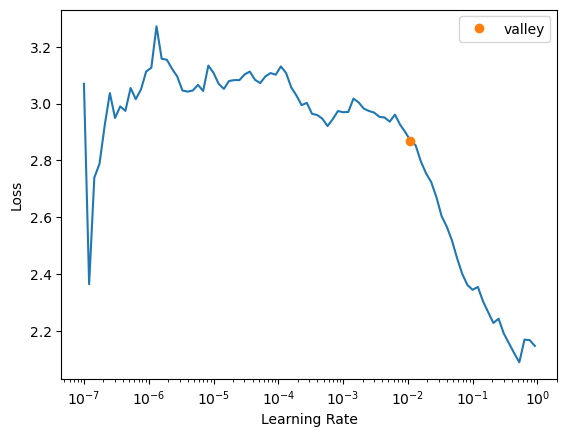

In [17]:
learn.lr_find()

In [17]:
# Train for a few epochs
learn.fit(8, lr=0.1)  # Very small LR to test

epoch,train_loss,valid_loss,mae,time
0,1.170908,0.470171,0.475311,00:00
1,0.756969,0.538938,0.606170,00:00
2,0.687669,0.492995,0.534384,00:00
3,0.634899,0.435458,0.466544,00:00
4,0.646756,0.479028,0.459652,00:00
5,0.623740,0.528676,0.514003,00:00
6,0.591713,0.490361,0.526057,00:00
7,0.595900,0.425440,0.410670,00:00


In [18]:
preds, targets = learn.get_preds(dl=dls.valid)


In [19]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

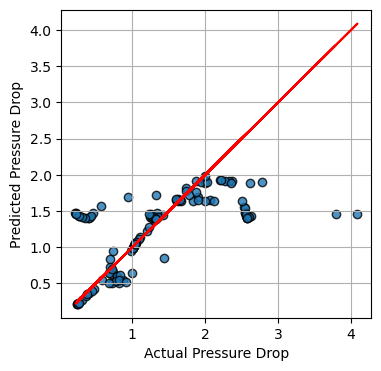

In [20]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.grid()
plt.show()

In [21]:
# Get embedding layers
def get_embeddings(learn, cat_var_name):
    """Extract embeddings for a specific categorical variable"""
    # Find the embedding layer for this variable
    emb_layer = None
    for name, layer in learn.model.embeds.named_children():
        if name == cat_var_name:
            emb_layer = layer
            break
    
    if emb_layer is None:
        print(f"Embedding layer for {cat_var_name} not found")
        return None
    
    # Extract weights (embedding matrix)
    embeddings = emb_layer.weight.data.cpu().numpy()
    return embeddings


In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [23]:
dls.classes['Geometry']

['#na#', 'backwardStep', 'bend', 'forwardStep', 'leftStripBend', 'rightStripBend', 'unknown']

In [24]:
reducer = PCA(n_components=2)

In [25]:
embeddings = get_embeddings(learn, '0')
embeddings_2d = reducer.fit_transform(embeddings)
embeddings_2d

array([[-0.03947722, -0.04565756],
       [ 1.5563627 , -0.27540317],
       [ 1.1753497 , -0.36273083],
       [ 0.6988189 ,  0.8479667 ],
       [-1.8383701 , -0.18506733],
       [-1.084552  ,  0.11332624],
       [-0.46813172, -0.09243373]], dtype=float32)

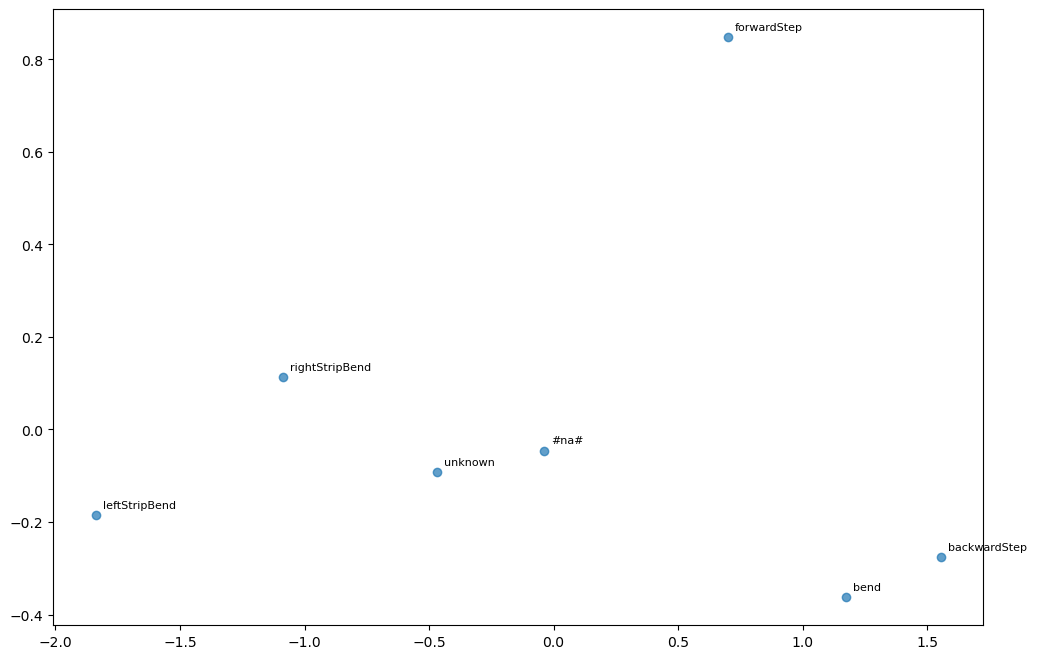

In [26]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
# Add labels for some points
for i, (x, y) in enumerate(embeddings_2d):
    plt.annotate(dls.classes['Geometry'][i], (x, y), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

In [27]:
save_pickle('models/unknonwModel.pkl', learn)